# Data Analysis of Layoffs in the United States Tech Industry 

## Project Motivation and Background

As Computer Science students about to enter the job market, we're concerned about the volatility of the tech industry. We want to analyze and create a system that can help people understand the markets, plan an exit strategy, and alleviate these concerns.

## Project Goal:
The goal of our project is to analyze trends in companies' recent layoffs in a variety of industries (aerospace, travel, retail, etc.) and detect patterns and trends.  This will be done by looking at the number of employees laid off, the location of the companies, their stages, and the funds they have raised.




In [16]:
import pandas as pd
import numpy as np

# Read in the data
layoffs = pd.read_csv('layoffs.csv')
layoffs.head()
print(layoffs.columns)
#we have to drop all rows with a blank percentage layed off cell
layoffs.dropna(subset=['percentage_laid_off'], inplace=True)


# one hot encoding for categorical variables 
print(f"Unique values for 'company': {len(layoffs['company'].unique())}")

# Adding dummy variables for location, industry, stage, and country
totalNewCols = len(layoffs['location'].unique()) + len(layoffs['industry'].unique()) + len(layoffs['stage'].unique()) + len(layoffs['country'].unique())
print(f"Total number of new columns: {totalNewCols}")


# loca = pd.get_dummies(layoffs['location'], prefix='location')
indu = pd.get_dummies(layoffs['industry'], prefix='industry')
stag = pd.get_dummies(layoffs['stage'], prefix='stage')
coun = pd.get_dummies(layoffs['country'], prefix='country')

# drop the original columns
layoffs.drop(['location', 'industry', 'stage', 'country'], axis=1, inplace=True)

# concat the new columns
layoffs = pd.concat([layoffs, indu, stag, coun], axis=1)
# layoffs = pd.concat([layoffs, indu, stag], axis=1)
layoffs.drop(['stage_Unknown'],axis=1,inplace=True)

layoffs.head()


Index(['company', 'location', 'industry', 'total_laid_off',
       'percentage_laid_off', 'date', 'stage', 'country', 'funds_raised'],
      dtype='object')
Unique values for 'company': 1438
Total number of new columns: 256


,company,total_laid_off,percentage_laid_off,date,funds_raised,industry_Aerospace,industry_Construction,industry_Consumer,industry_Crypto,industry_Data,...,country_South Korea,country_Spain,country_Sweden,country_Switzerland,country_Thailand,country_Turkey,country_United Arab Emirates,country_United Kingdom,country_United States,country_Vietnam
0,N26,71.0,0.04,2023-04-28,1700.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,Providoor,NaN,1.00,2023-04-28,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Dropbox,500.0,0.16,2023-04-27,1700.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Vroom,120.0,0.11,2023-04-27,1300.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,Greenhouse,100.0,0.12,2023-04-27,110.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [17]:
traing_data = layoffs.drop(['company', 'date'], axis=1)

# Split the data into training and testing sets
train_set = traing_data.sample(frac=0.8, random_state=0)
test_set = traing_data.drop(train_set.index)

print (f"Training set shape: {train_set.shape}")
print (f"Testing set shape: {test_set.shape}")

Training set shape: (1355, 96)
Testing set shape: (339, 96)


In [18]:

from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from numpy import arange
from sklearn.ensemble import VotingRegressor

X_train = train_set.drop(['percentage_laid_off'], axis=1)
X_train = X_train.fillna(0)

y_train = train_set["percentage_laid_off"]

X_test = test_set.drop(['percentage_laid_off'], axis=1)
print(X_test.columns)
X_test = X_test.fillna(0)

y_test = test_set['percentage_laid_off']


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=0)

RidgeCV = RidgeCV(alphas=arange(0.000001, 1.000001, 0.01), cv = cv)

RidgeCV.fit(X_train, y_train)

y_pred = RidgeCV.predict(X_test)

print(f"RidgeCV R2 score: {r2_score(y_test, y_pred)}")




Index(['total_laid_off', 'funds_raised', 'industry_Aerospace',
       'industry_Construction', 'industry_Consumer', 'industry_Crypto',
       'industry_Data', 'industry_Education', 'industry_Energy',
       'industry_Finance', 'industry_Fitness', 'industry_Food', 'industry_HR',
       'industry_Hardware', 'industry_Healthcare', 'industry_Infrastructure',
       'industry_Legal', 'industry_Logistics', 'industry_Manufacturing',
       'industry_Marketing', 'industry_Media', 'industry_Other',
       'industry_Product', 'industry_Real Estate', 'industry_Recruiting',
       'industry_Retail', 'industry_Sales', 'industry_Security',
       'industry_Support', 'industry_Transportation', 'industry_Travel',
       'stage_Acquired', 'stage_Post-IPO', 'stage_Private Equity',
       'stage_Seed', 'stage_Series A', 'stage_Series B', 'stage_Series C',
       'stage_Series D', 'stage_Series E', 'stage_Series F', 'stage_Series G',
       'stage_Series H', 'stage_Series I', 'stage_Series J',
       'sta

R ** 2 score: 0.30480895857786616
variance: 0.3071394706300361
mse: 0.04026049845810046
mae: 0.14663207695160854


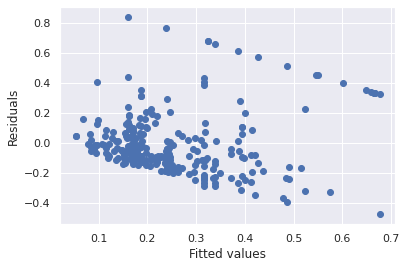

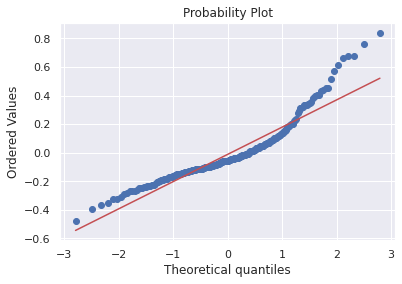

ValueError: continuous is not supported

In [39]:
import matplotlib.pyplot as plt

# X_test = test_set.drop(['percentage_laid_off', 'total_laid_off'], axis=1)
# X_test = X_test.fillna(0)
# y_test = test_set["percentage_laid_off"]
# y_predict = model.predict(X_test)

# X_test.to_csv('test_X.csv',index=False)
# y_test.to_csv('test_Y.csv',index=False)

# y_predict_df = pd.DataFrame(y_predict, columns=['percentage_laid_off'])

# #print("xtest: ", X_test.head(5))




# print(y_test.size)
# print(arange(0,508,1).size)

# Plot outputs
plt.scatter(arange(0,508,1), y_test, color="black")
plt.plot(arange(0,508,1), y_predict, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())
#the output of this is really ugly dw about it
plt.show()


mae = mean_absolute_error(y_test, y_predict)
print(f'mae: {mae}')


# residuals vs fitted values
import matplotlib.pyplot as plt
plt.scatter(y_predict, y_test - y_predict)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

# Normal Q-Q plot
import scipy.stats as stats
import pylab
stats.probplot(y_test - y_predict, dist="norm", plot=pylab)
pylab.show()




In [40]:

print("======================")
print("Predictions:")
print(y_predict_df.head(20))
print(y_test.reset_index(drop=True).head(20))

# put the predictions and actual values into a dataframe and do head to head comparison
predictions = pd.concat([y_test.reset_index(drop=True), y_predict_df], axis=1)
predictions.columns = ['actual', 'predicted']
print(predictions.head(20))




print("======================")


Predictions:
    percentage_laid_off
0              0.385498
1              0.247519
2              0.240291
3              0.394545
4              0.649684
5              0.161085
6              0.263073
7              0.240121
8              0.317366
9              0.247451
10             0.187187
11             0.118454
12             0.171499
13             0.155730
14             0.227644
15             0.218486
16             0.095426
17             0.478469
18             0.092234
19             0.244628
0     0.40
1     0.25
2     0.20
3     0.17
4     1.00
5     0.40
6     0.10
7     0.20
8     0.20
9     0.45
10    0.16
11    0.02
12    0.25
13    0.20
14    0.14
15    0.08
16    0.03
17    0.11
18    0.08
19    0.14
Name: percentage_laid_off, dtype: float64
    actual  predicted
0     0.40   0.385498
1     0.25   0.247519
2     0.20   0.240291
3     0.17   0.394545
4     1.00   0.649684
5     0.40   0.161085
6     0.10   0.263073
7     0.20   0.240121
8     0.20   0.317366
9

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
print("======================")
print(y_test.reset_index(drop=True).head(20))
print("======================")